### 0.0. Dependencies and Data

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [107]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [108]:
print(retail_areas.dtypes)

date                                                       object
id                                                          int64
events                                                      int64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local_Footprint_Centre_ID                                  object
Residential Population (Weighted Catchment)                 int64
Retail Footprint Score                                    float64
Base Score                                                float64
Tourism Score                                             float64
Convenience_Score                                         float64
Retail_Footprint_Comparison_Retailer_Score                float64
Leisure_Footprint_Score                                   float64
Auto_Score                                                float64
Local Foot

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

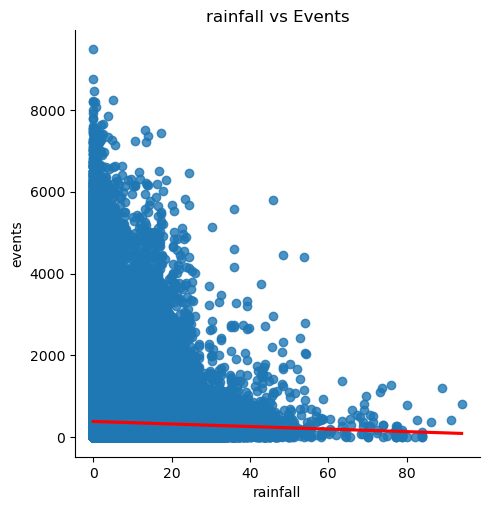

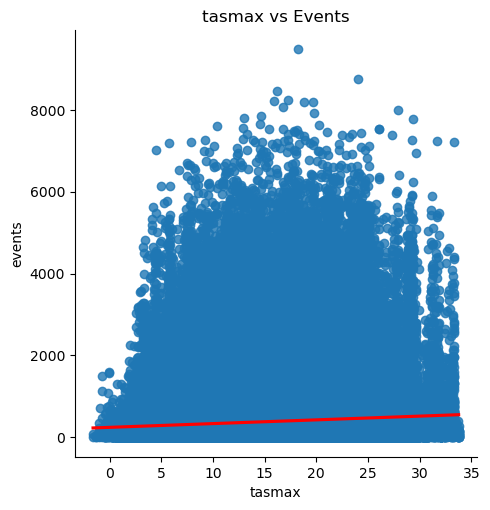

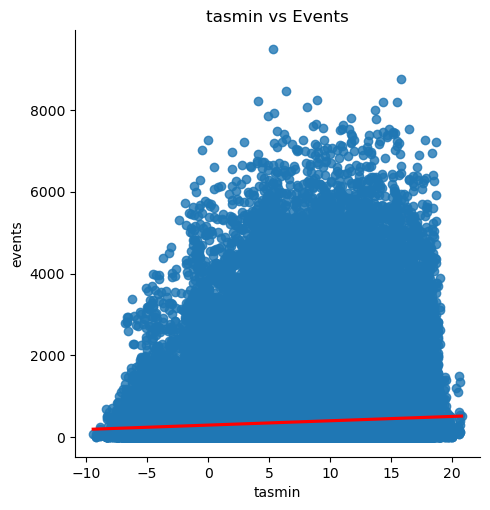

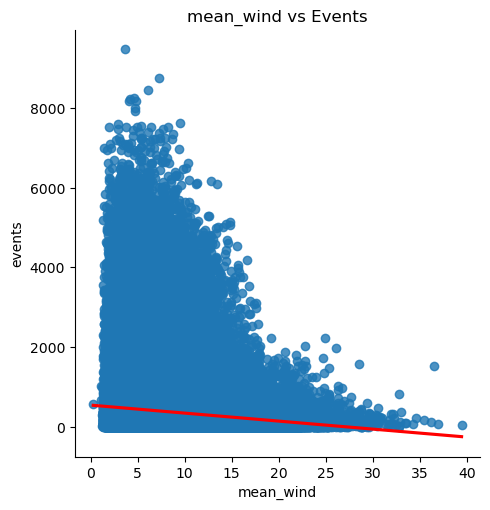

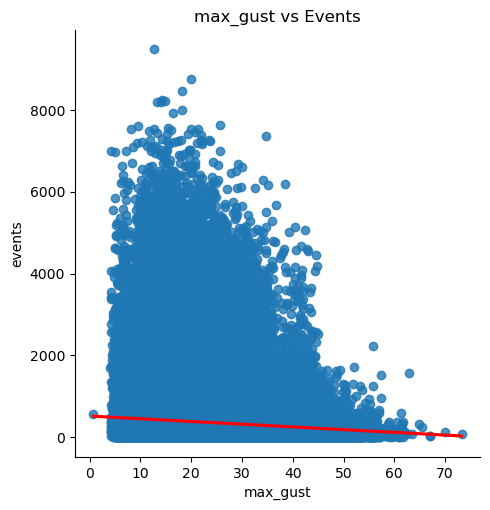

In [109]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.lmplot(x=var, y='events', data=retail_areas, line_kws={'color': 'red'})
    plt.title(f'{var} vs Events')
    plt.show() 

#### 1.1.2. Var encoding

In [110]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

In [129]:
# how many unique IDs per unique date?

### 1.2. General Model

#### 1.2.1. Without weather

Train/test:

In [130]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [131]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 5)
(418176,)
(104544, 5)
(104544,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6523281735700207
R² on the testing data:
0.6471284154113246


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6743775968018126
R² on the testing data:
0.6672446957917755


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
356.4298850821837
RMSE on the testing data:
360.7536402168503


                                             Importance
Feature                                                
Retail Footprint Score                         1.340540
Tourism Score                                  1.248017
Residential Population (Weighted Catchment)    1.145985
weekend                                        0.011423
holiday                                        0.004671


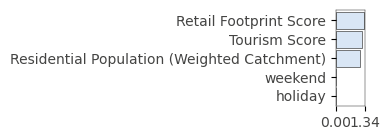

In [ ]:
from rfpimp import importances

imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.2. Add more vars

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
    'coastal'
] + [col for col in df_model.columns 
     if col.startswith('season_') or col.startswith('groupName_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(features)

['Residential Population (Weighted Catchment)', 'Retail Footprint Score', 'weekend', 'holiday', 'Tourism Score', 'coastal', 'season_Spring', 'season_Summer', 'season_Winter']


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 9)
(418176,)
(104544, 9)
(104544,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

KeyboardInterrupt: 

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.7347559783376159
R² on the testing data:
0.7282616419414961


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.7404485455490413
R² on the testing data:
0.7325503882133245


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
356.40553762402834
RMSE on the testing data:
360.7294228443866


                                                    Importance
Feature                                                       
Tourism Score                                         1.396384
Retail Footprint Score                                1.317568
Residential Population (Weighted Catchment)           0.827162
groupName_Indie high streets                          0.405358
groupName_Sub-regional retail and leisure desti...    0.193271
groupName_Mass and value high streets                 0.081830
groupName_Large regional retail and leisure des...    0.072834
groupName_Secondary retail parks and shopping c...    0.057118
groupName_Local urban convenience centres             0.048731
season_Winter                                         0.038987
season_Spring                                         0.015568
weekend                                               0.011030
season_Summer                                         0.007384
coastal                                               0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


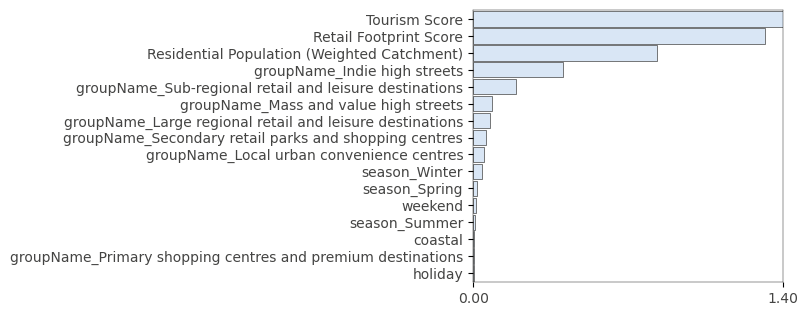

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.1. With weather

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'weekend',
    'holiday',
    'Tourism Score',
    'coastal'
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_') or col.startswith('Sparsity_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 9)
(289303,)
(72326, 9)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

KeyboardInterrupt: 

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9341828553166651
R² on the testing data:
0.5474845343981463


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9341828553166651
R² on the testing data:
0.5474845343981463


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
176.43797146575662
RMSE on the testing data:
476.0554237676004


                                                    Importance
Feature                                                       
Retail Footprint Score                                1.580380
Sparsity_5 - Urban Dense (London)                     0.699190
Residential Population (Weighted Catchment)           0.664867
groupName_Sub-regional retail and leisure desti...    0.394477
Tourism Score                                         0.219045
groupName_Mass and value high streets                 0.077860
groupName_Indie high streets                          0.063539
Sparsity_6 - Retail Park                              0.052842
groupName_Local urban convenience centres             0.042228
groupName_Secondary retail parks and shopping c...    0.037087
groupName_Large regional retail and leisure des...    0.034061
Sparsity_4 - Urban Dense                              0.025149
Sparsity_2 - Small Urban                              0.009985
Sparsity_3 - Urban                                    0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


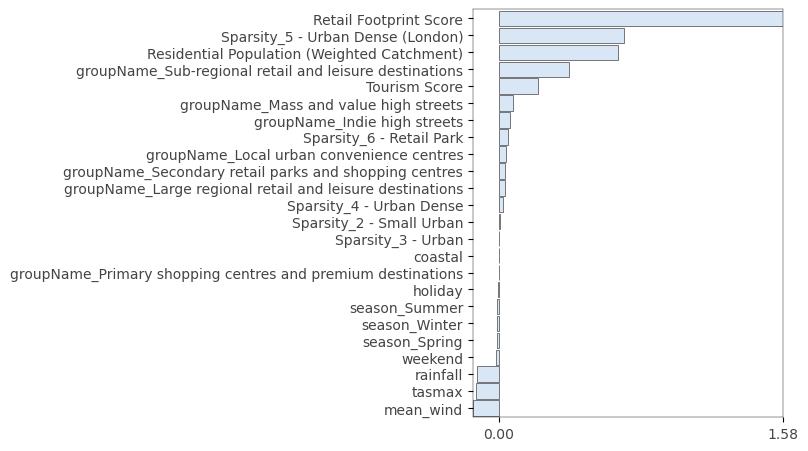

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 1.3. Model w/ retail type

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

#### 1.3.1. Without weather

Calibration:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Model:

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'weekend',
    'holiday',
    'Tourism Score',
    'coastal'
] + [col for col in df_model.columns if col.startswith('season_') or col.startswith('Sparsity_')]

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



Group: District urban service centres
R² (train): 0.701 | R² (test): 0.688
Feature Importances:
Sparsity_5 - Urban Dense (London)              0.487
Retail Footprint Score                         0.231
Tourism Score                                  0.168
Residential Population (Weighted Catchment)    0.060
season_Winter                                  0.019
season_Spring                                  0.014
weekend                                        0.009
season_Summer                                  0.005
holiday                                        0.004
coastal                                        0.001
Sparsity_3 - Urban                             0.001
Sparsity_2 - Small Urban                       0.001
Sparsity_4 - Urban Dense                       0.001
Sparsity_6 - Retail Park                       0.000
dtype: float64

Group: Indie high streets
R² (train): 0.760 | R² (test): 0.734
Feature Importances:
Retail Footprint Score                         0.260
Tourism 

Add calibration:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



#### 1.3.2. With weather

In [ ]:
group_col = 'groupName'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'weekend',
    'holiday',
    'Tourism Score',
    'coastal'
] + weather_vars + [col for col in df_model.columns if 
                    col.startswith('season_') or col.startswith('Sparsity_')]
 
# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # Scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
R² (train): 0.922 | R² (test): 0.404
Feature Importances:
Tourism Score                                  0.407
Retail Footprint Score                         0.232
mean_wind                                      0.088
max_gust                                       0.083
Residential Population (Weighted Catchment)    0.045
tasmax                                         0.037
tasmin                                         0.036
rainfall                                       0.033
season_Winter                                  0.013
season_Spring                                  0.012
weekend                                        0.007
season_Summer                                  0.003
coastal                                        0.002
holiday                                        0.001
dtype: float64

Group: Indie high streets
R² (train): 0.947 | R² (test): 0.622
Feature Importances:
Retail Footprint Score                         0.276
Tourism 

Add calibration:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


Partial dependence plots:

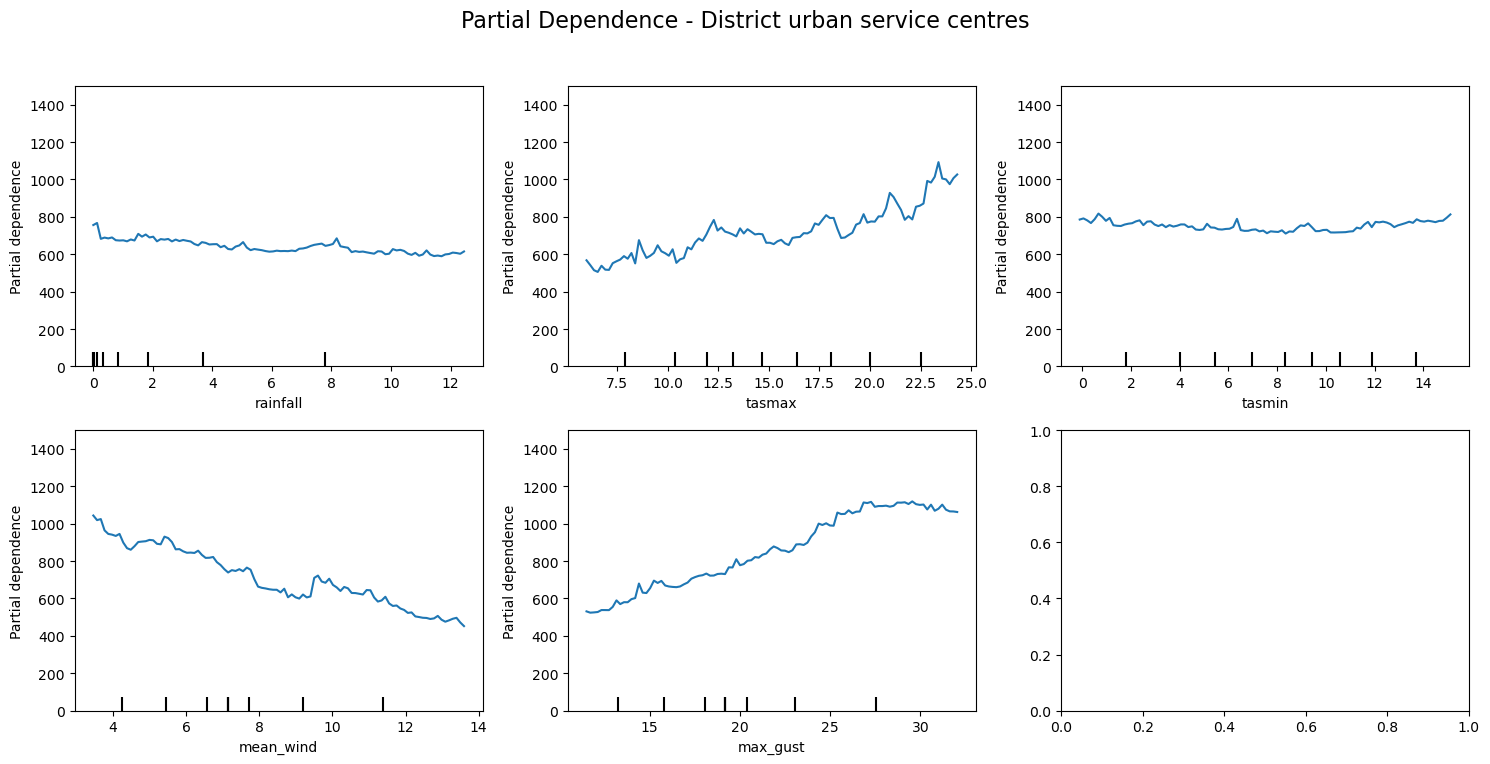

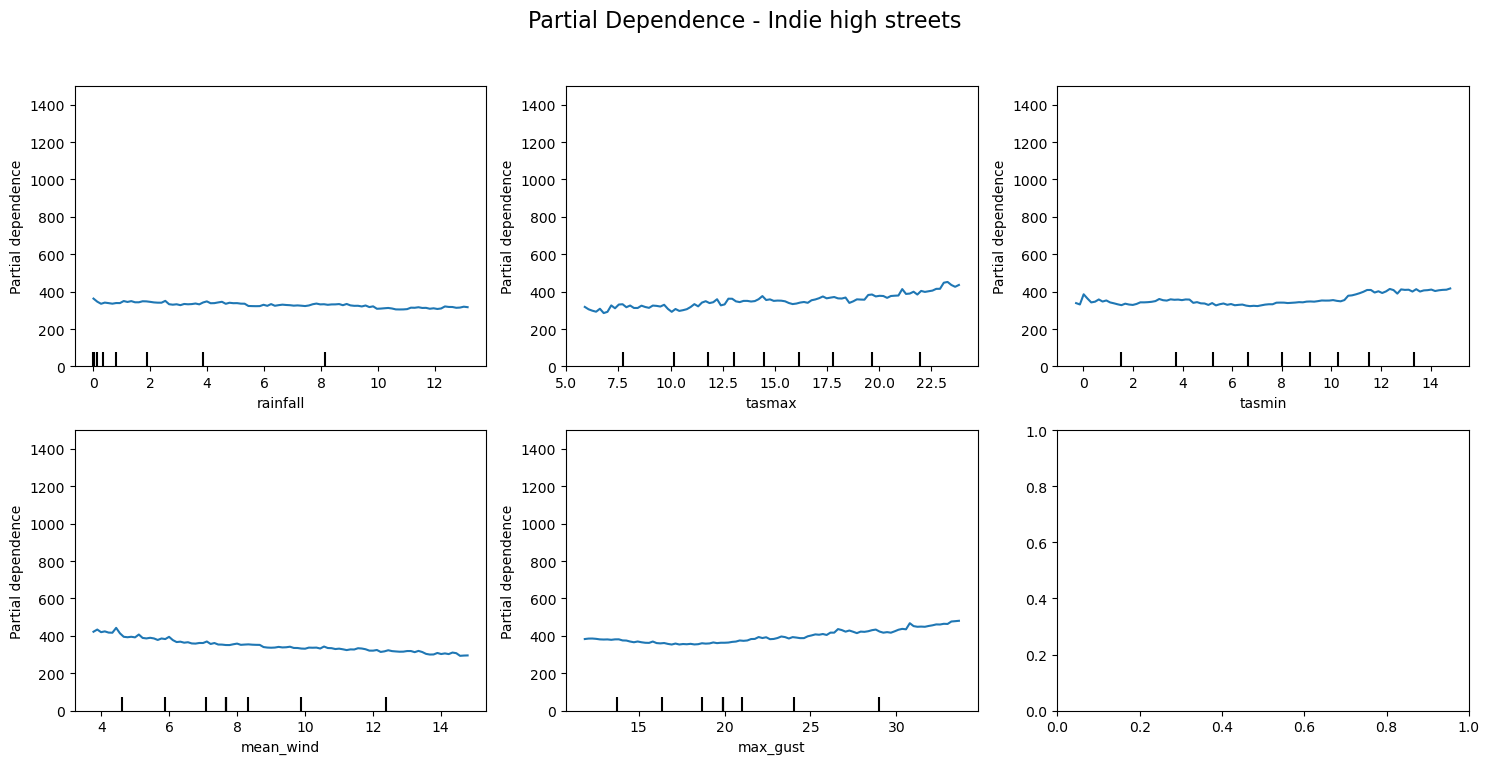

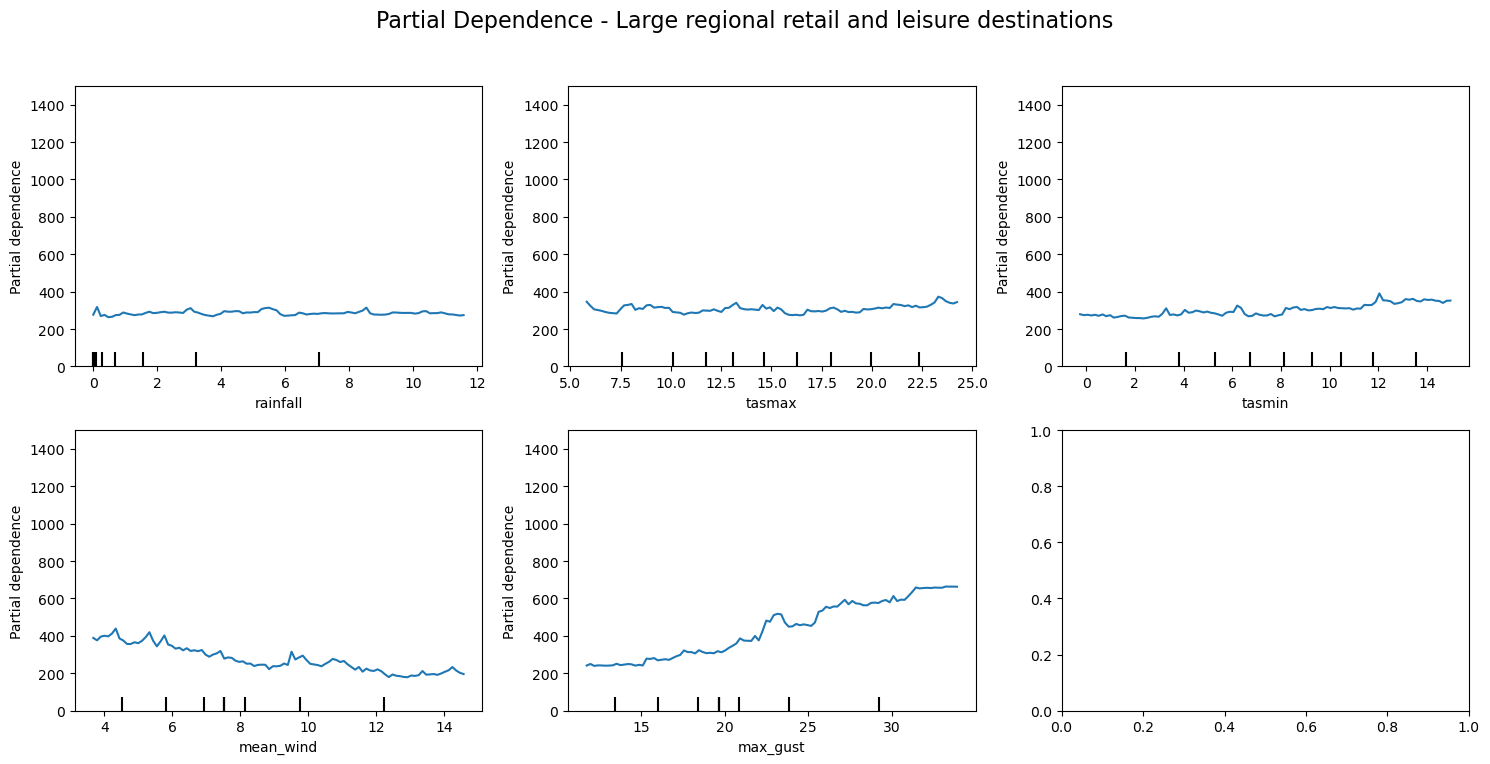

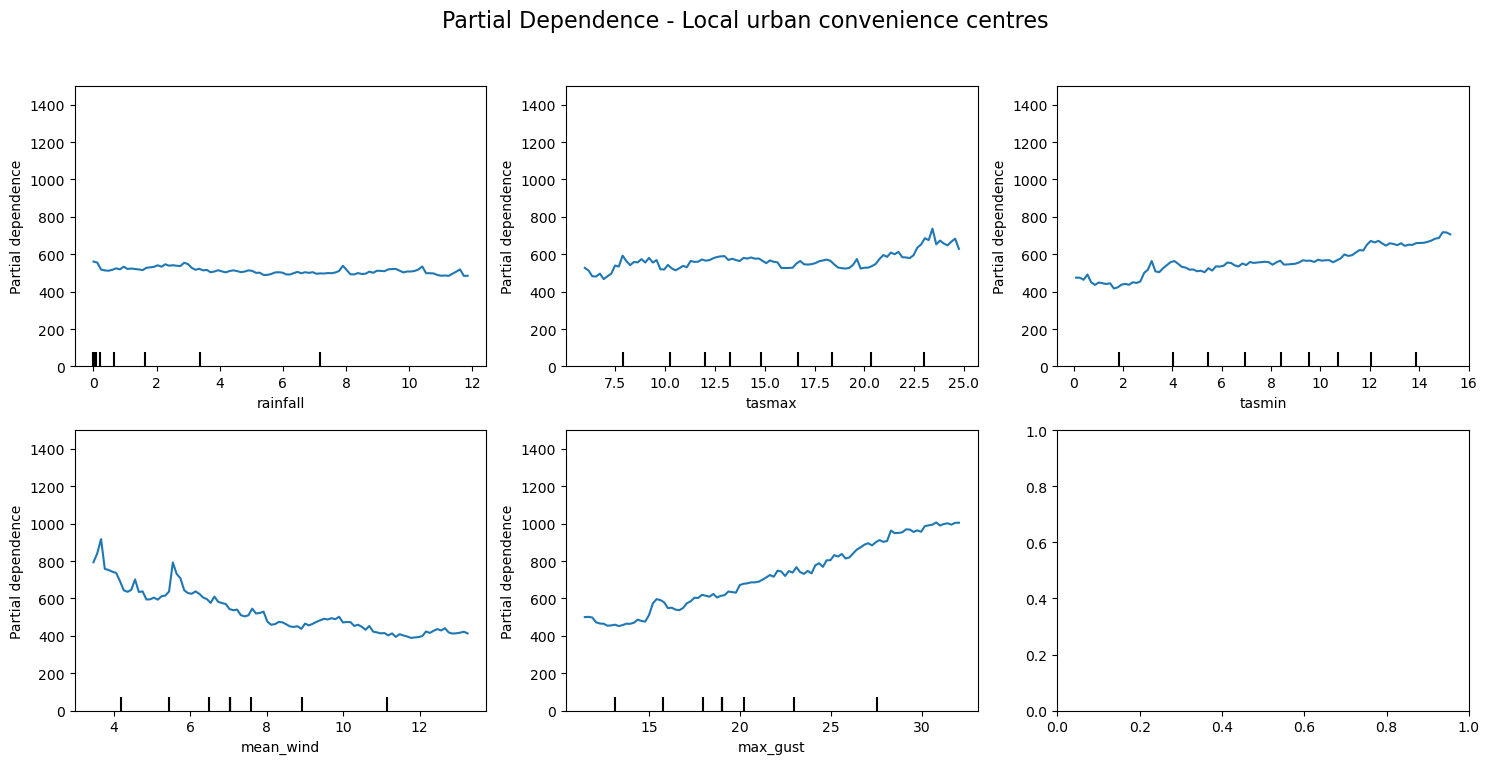

KeyboardInterrupt: 

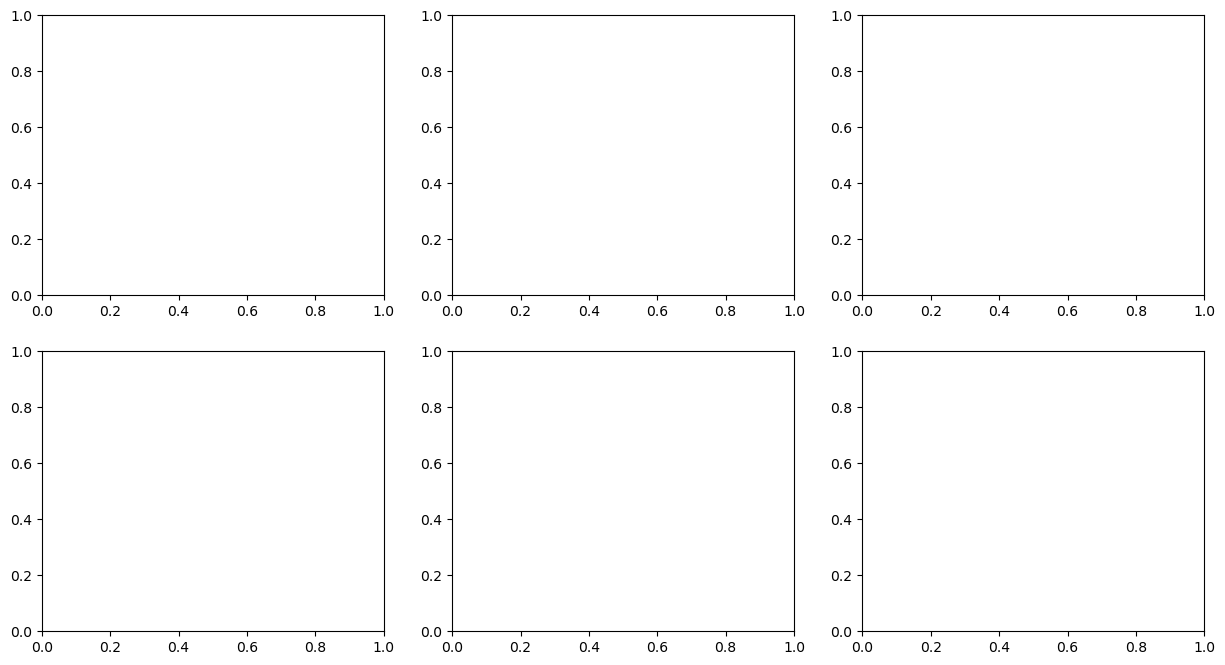

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # Skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # Handle missing values (robustness)
    X = X.fillna(X.median())

    # Fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # Prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # Plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # Optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 1.4. Retail model per sparsity

In [ ]:
#...

#### later

region?
rail/tube--- specifically for london?